In [1]:
import csv
import cv2
import numpy as np

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pwd

'/Volumes/Macintosh_HD/Users/deanliu/git/Udacity/CarND/CarND-Behavioral-Cloning-P3'

In [6]:
# Load data
# data_path = './data/' # default sim data from Udacity
data_path = '../Simulator/' # my sim data
# data_path = './training_data/'

csv_file = data_path + 'driving_log.csv'
lines = []
with open(csv_file) as f:
  reader = csv.reader(f)
  next(reader) # skip 1st line
  for line in reader:
    lines.append(line)

In [9]:
images = []
measurements = []
for line in lines:
  source_path = line[0] #center channel video
  filename = source_path.split('/')[-1] #remove intermediate path
  image_file = data_path + 'IMG/' + filename
  image = cv2.imread(image_file, cv2.COLOR_BGR2RGB)
  images.append(image)

  measurement = float(line[3]) #steering angle
  measurements.append(measurement)

In [10]:
images[0][40:,:,:].shape

(120, 320, 3)

(array([   39.,   213.,   342.,  1025.,   664.,    67.,    55.,    33.,
           21.,     6.]),
 array([-0.2477521 , -0.18914729, -0.13054248, -0.07193767, -0.01333286,
         0.04527195,  0.10387676,  0.16248157,  0.22108638,  0.27969119,
         0.338296  ]),
 <a list of 10 Patch objects>)

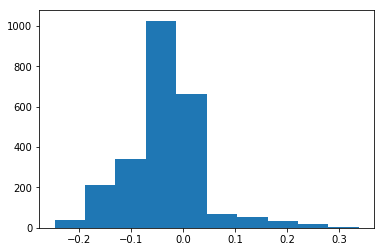

In [14]:
plt.hist(measurements)

In [ ]:
measurements.extend()

In [15]:
-np.array(measurements)

array([-0., -0., -0., ..., -0., -0., -0.])

In [16]:
X_train = np.array(images)
y_train = np.array(measurements)

# generate flipped image data
X_train_flip = np.array(np.fliplr(images))
y_train_flip = -np.array(measurements)

In [17]:
whos

Variable       Type             Data/Info
-----------------------------------------
X_train        ndarray          2465x160x320x3: 378624000 elems, type `uint8`, 378624000 bytes (361.083984375 Mb)
X_train_flip   ndarray          2465x160x320x3: 378624000 elems, type `uint8`, 378624000 bytes (361.083984375 Mb)
csv            module           <module 'csv' from '/Volu<...>m1/lib/python3.5/csv.py'>
csv_file       str              ../Simulator/driving_log.csv
cv2            module           <module 'cv2' from '/Volu<...>2.cpython-35m-darwin.so'>
data_path      str              ../Simulator/
f              TextIOWrapper    <_io.TextIOWrapper name='<...>ode='r' encoding='UTF-8'>
filename       str              center_2017_03_28_16_08_39_778.jpg
image          ndarray          160x320x3: 153600 elems, type `uint8`, 153600 bytes (150.0 kb)
image_file     str              ../Simulator/IMG/center_2<...>17_03_28_16_08_39_778.jpg
images         list             n=2465
line           list         

In [18]:
X_train = np.concatenate((X_train, X_train_flip), axis=0)
y_train = np.concatenate((y_train, y_train_flip), axis=0)

In [19]:
whos

Variable       Type             Data/Info
-----------------------------------------
X_train        ndarray          4930x160x320x3: 757248000 elems, type `uint8`, 757248000 bytes (722.16796875 Mb)
X_train_flip   ndarray          2465x160x320x3: 378624000 elems, type `uint8`, 378624000 bytes (361.083984375 Mb)
csv            module           <module 'csv' from '/Volu<...>m1/lib/python3.5/csv.py'>
csv_file       str              ../Simulator/driving_log.csv
cv2            module           <module 'cv2' from '/Volu<...>2.cpython-35m-darwin.so'>
data_path      str              ../Simulator/
f              TextIOWrapper    <_io.TextIOWrapper name='<...>ode='r' encoding='UTF-8'>
filename       str              center_2017_03_28_16_08_39_778.jpg
image          ndarray          160x320x3: 153600 elems, type `uint8`, 153600 bytes (150.0 kb)
image_file     str              ../Simulator/IMG/center_2<...>17_03_28_16_08_39_778.jpg
images         list             n=2465
line           list          

(array([    7.,    65.,   218.,   496.,  1751.,  1607.,   496.,   218.,
           65.,     7.]),
 array([ -3.38296000e-01,  -2.70636800e-01,  -2.02977600e-01,
         -1.35318400e-01,  -6.76592000e-02,   5.55111512e-17,
          6.76592000e-02,   1.35318400e-01,   2.02977600e-01,
          2.70636800e-01,   3.38296000e-01]),
 <a list of 10 Patch objects>)

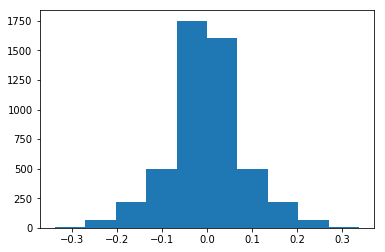

In [20]:
plt.hist(y_train)

(array([    6.,    21.,    33.,    55.,    67.,   664.,  1025.,   342.,
          213.,    39.]),
 array([-0.338296  , -0.27969119, -0.22108638, -0.16248157, -0.10387676,
        -0.04527195,  0.01333286,  0.07193767,  0.13054248,  0.18914729,
         0.2477521 ]),
 <a list of 10 Patch objects>)

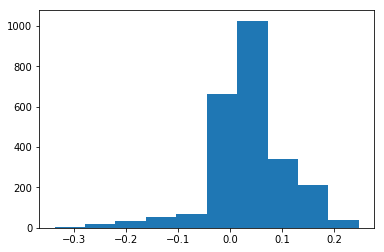

In [21]:
plt.hist(y_train_flip)

In [25]:
# train model  
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Cropping2D
from keras.layers.convolutional import Conv2D

In [49]:
imshape = X_train[0].shape

model = Sequential()

model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape=imshape, name='crop'))
model.add(Lambda(lambda x: (x/255.0)-0.5, name='lambda'))
model.add(Conv2D(nb_filter=6,
                 nb_row=5,
                 nb_col=5,
                 subsample=(1,1),
                 border_mode='valid',
                 activation='relu',
                 name='conv1'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool'))
model.add(Conv2D(nb_filter=6,
                 nb_row=5,
                 nb_col=5,
                 subsample=(1,1),
                 border_mode='valid',
                 activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2'))
model.add(Flatten(name='flat'))
model.add(Dense(120, activation='relu', name='dense1'))
model.add(Dense(84, activation='relu', name='dense2'))
model.add(Dense(1, name='dense3'))

In [50]:
layer = model.get_layer('crop')
print(layer.get_input_shape_at(0))
print(layer.get_output_shape_at(0))

(None, 160, 320, 3)
(None, 90, 320, 3)


In [60]:
model.get_layer(name='maxpool').get_input_shape_at(0)

(None, 86, 316, 6)

In [75]:
for layer in model.layers:
    print(layer.get_input_shape_at(0), layer.name)

(None, 160, 320, 3) crop
(None, 90, 320, 3) lambda
(None, 90, 320, 3) conv1
(None, 86, 316, 6) maxpool
(None, 43, 158, 6) conv2
(None, 39, 154, 6) maxpool2
(None, 19, 77, 6) flat
(None, 8778) dense1
(None, 120) dense2
(None, 84) dense3


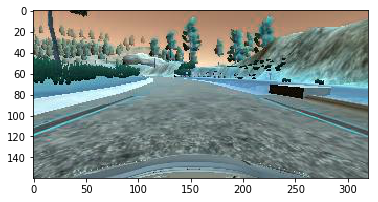

In [43]:
plt.imshow(X_train[1000])

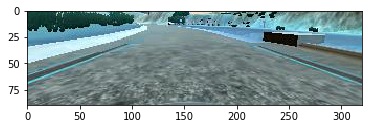

In [44]:
plt.imshow(X_train[1000][50:-20])

In [ ]:
model.compile(loss='mse',
              optimizer='adam')
model.fit(X_train, y_train,
          validation_split=0.2,
          shuffle=True,
          nb_epoch=8)

model.save('model.h5')